## **Project3：Meta-Labeling應用示範**

### **動機**

由於金融市場在不同時段其市場結構（Market Regime）可能大相逕庭，直接在原始價格資料上套用機器學習模型往往容易失敗。Meta-Labeling 的核心想法在於：

1. 先透過一個「初步模型（Primary Model）」檢測出市場結構或可能的信號，
2. 再以機器學習做第二層篩選，產生更穩健的交易決策。

---

### **流程概述**

1. **Primary Model：CUSUM Filter + Triple Barrier Method**

   * 使用 CUSUM 濾波器（CUSUM Filter）作為初步信號產生器，偵測價格累積變動是否突破當前波動門檻。
   * 針對每個 CUSUM 事件（t\_event），套用 Triple Barrier Method（上下界 + 垂直界）進行標籤（Labeling），將事件標記為「多頭／空頭／中性」。
   * 同時計算每筆事件的「唯一性」（Uniqueness），並根據其唯一性分配樣本權重，使訓練資料更接近 i.i.d. 分佈，降低模型過度擬合風險。

2. **特徵來源整合**

   * 將 Project1（以 PCA 或其他方法完成的商品分群結果）所選出的商品列表作為分析對象。
   * 將 Project2 中計算出的「重要指標」作為模型輸入，確保只選用在先前分析中證明具有顯著貢獻的技術指標或統計特徵。

3. **自訂 Random Forest 作為二層模型**

   * 為了克服金融資料非 i.i.d. 的特性，本專案實作一個 Custom Random Forest，修改其 Bootstrap 抽樣機制，使每棵決策樹以「樣本權重」作為抽樣依據。
   * 將第一步所標記的事件（含 Label 與權重）與第二步選出的特徵一起，輸入自訂 Random Forest 進行訓練。
   * 最終比較 Train/Test 資料集上的模型效能，以驗證 Meta-Labeling 策略在不同商品上的適用性與泛化能力。

---

### **核心特色說明**

* **CUSUM Filter**

  * 依據近 N 日移動波動率計算上下門檻，當價格累積變動值超過該閾值時，紀錄一個 CUSUM 事件。
  * 有效抓取顯著且連續的價格偏離，避免單純以固定時間間隔下單帶來的雜訊。

* **Triple Barrier Method**

  * 包含三個停界： 

    1. **停利門檻**：以倍數乘上事件發生當時的目標波動率（Target Volatility）。
    2. **停損門檻**：同樣以倍數乘上目標波動率。
    3. **垂直停界**：設定事件發生後的最大存活時間（例如 2 個交易日）。
  * 依據三者先觸發的情況，將該事件標記為「多頭」（觸及停利）、「空頭」（觸及停損）或「中性」（觸及垂直界仍未達停利／停損）。

* **Uniqueness 加權**

  * 每筆事件可能與其他事件存在時間重疊，Uniqueness 衡量單一事件在所有事件集合中的相對獨立性。
  * 權重計算範例：
    $\text{Uniqueness}(i) = \frac{1}{\sum_{j=1}^{M} \mathbf{1}\{i \text{ 和 } j \text{ 之間有重疊}\}}$
  * 藉由此機制，減少重疊性過高的事件在訓練集中被重複抽樣的機率。

* **自訂 Random Forest**

  * Sklearn 內建 RF 在 Bootstrap 時是均勻隨機抽樣，不考慮樣本權重。
  * Custom RF 以「Uniqueness 權重」作為抽樣機率，確保重疊度高的事件不會主導模型訓練。
---

> **Warning**：本專案重點在於示範，並非要跑出極致的策略績效。若要在實際交易環境應用，仍需進一步加入嚴格的回測流程（如 Purged K-Fold CV、PBO、CPCV）、風險管理與動態參數調整等要素。

---


### **讀取資料**
- 讀取黃金所在群集資料，並將資料轉化為dollar bars

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join("..", "QuantCommon"))
if project_root not in sys.path:
    sys.path.append(project_root)

# utils為我自己編寫的常用工具庫，檔案不在此作品集內
from utils.processing import get_dollar_bars 
import numpy as np
import pandas as pd
import numpy as np


clusters = pd.read_csv("results/clusters.csv", index_col=0)

group = clusters[clusters["cluster"] == clusters.loc["XAUUSD_M1", "cluster"]]
data = dict({})
for i in group.index:
    print(f"Processing {i[:-3]}...")
    filepath = os.path.join(project_root, "data", "FI", "M1",f"{i}.csv")
    df = pd.read_csv(filepath, parse_dates=True)
    df['time'] = pd.to_datetime(df['time'])
    df = get_dollar_bars(df)
    data[i[:-3]] = df

Processing AUDUSD...
Processing EURUSD...
Processing GBPUSD...
Processing HK50...
Processing JP225...
Processing NZDUSD...
Processing UK100...
Processing US2000...
Processing USDCAD...
Processing XAGUSD...
Processing XAUUSD...


### **Metalabeling**
- primary model 為 cusum filter, 當價格變動超過前20日波動平均時做多
- 用trible barrier method進行metalabeling
- 依資料的uniqueness產生權重，讓模型訓練時資料能接近i.i.d.
- 計算指標作為features，並將features標準化為建立多商品做準備

In [2]:
from utils.metalabeling import add_vertical_barrier, get_events, get_bins
from utils.processing import apply_cusum_filter, getDailyVol, cal_weights, compute_talib_features
from joblib import load

feats_list, labels_list, weights_list, t1_list = [], [], [], []
pca_pipe = load("models/pipeline_scaler_pca.joblib")

for symbol,df in data.items():
    print(f"Processing {symbol}...")
    vol = getDailyVol(df["close"], span0=20)
    cusum_events  = apply_cusum_filter(df, volatility=vol).index
    vertical_barriers = add_vertical_barrier(cusum_events, df, num_days=2)
    pt_sl = [1, 1]
    min_ret = 0.003
    triple_barrier_events = get_events(close=df["close"],
                                                t_events=cusum_events,
                                                pt_sl=pt_sl,
                                                target=vol,
                                                min_ret=min_ret,
                                                num_threads=4,
                                                vertical_barrier_times=vertical_barriers,
                                                side_prediction=None)
    labels  = get_bins(triple_barrier_events, df["close"])
    weights = cal_weights(triple_barrier_events, df["close"])
    feats = compute_talib_features(df,
                               periods=[7,28,50,100],
                               apply_ffd=True)
    
    # normalize features
    for col in feats.columns:
        # 每個 col 分別做 rolling.apply
        feats[col] = (
            feats[col]
            .rolling(window=200, min_periods=1)
            .apply(lambda arr: (arr <= arr[-1]).sum() / len(arr), raw=True)
        )
    idx = feats.index.intersection(labels.index)
    feats = feats.loc[idx]
    labels = labels.loc[idx]["bin"]
    weights = weights.loc[idx]["weight"]
    weights = weights / weights.mean() # normalize weights
    t1 = triple_barrier_events.loc[idx]["t1"]

    # apply PCA
    pca_results = pca_pipe.transform(feats)
    col = [f"PCA_{i}" for i in range(pca_results.shape[1])]
    feats = pd.DataFrame(pca_results, columns= col, index=feats.index)

    feats_list.append(feats)
    labels_list.append(labels.rename("label"))
    weights_list.append(weights.rename("weight"))
    t1_list.append(t1.rename("t1"))


from joblib import dump
# 儲存中間結果
dump(
    (feats_list, labels_list, weights_list, t1_list),
    "intermediate_results/events_data.joblib",
    compress=3  # 可選壓縮等級，0-9
)




Processing AUDUSD...
Processing EURUSD...
Processing GBPUSD...
Processing HK50...
Processing JP225...
Processing NZDUSD...
Processing UK100...
Processing US2000...
Processing USDCAD...
Processing XAGUSD...
Processing XAUUSD...


['intermediate_results/events_data.joblib']

### **篩選特徵**
- 以Project2計算之mdi, mda, sfi前50%的交集作為訓練特徵

In [3]:
# 讀取存檔
from joblib import load
feats_list, labels_list, weights_list, t1_list = load("intermediate_results/events_data.joblib")

import pandas as pd

mdi = pd.read_csv("results/mdi.csv", index_col=0)
mda = pd.read_csv("results/mda.csv", index_col=0)
sfi = pd.read_csv("results/sfi.csv", index_col=0)


imp_list = [mdi, mda, sfi]

top_half_index_sets = []

for imp in imp_list:
    cutoff = imp["mean"].quantile(0.5)

    print(f"中位數 cutoff: {cutoff}")
    top_half = imp[imp["mean"] >= cutoff].index
    top_half_index_sets.append(set(top_half))


selected_col = list(top_half_index_sets[0] & top_half_index_sets[1] & top_half_index_sets[2])

print("三項Feature Importance 中前 50% 的交集：")
print(selected_col)


中位數 cutoff: 0.03094031728386125
中位數 cutoff: -0.00014235746230870002
中位數 cutoff: -0.6938918639070157
三項Feature Importance 中前 50% 的交集：
['PCA_2', 'PCA_11', 'PCA_20', 'PCA_16']


### **Train Test split**
- 以2022年後的資料作為test dataset
- 由於資料包含多種商品，用比率切割可能會導致回測時資訊洩漏，所以用固定時間來切割資料

In [4]:
cutoff_date = pd.Timestamp("2023-01-01 00:00:00")
symbol = list(data.keys())


train_X_dict = dict({})
train_y_dict = dict({})
train_weights_dict = dict({})
train_t1_dict = dict({})
test_X_dict = dict({})
test_y_dict = dict({})
for i in range(len(feats_list)):
    train_X_dict[symbol[i]] = feats_list[i][feats_list[i].index < cutoff_date][selected_col]
    train_y_dict[symbol[i]] = labels_list[i][labels_list[i].index < cutoff_date]

    weights = weights_list[i]/ weights_list[i].mean()  # normalize weights
    train_weights_dict[symbol[i]] = weights_list[i][weights_list[i].index < cutoff_date]
    train_t1_dict[symbol[i]] = t1_list[i][t1_list[i].index < cutoff_date]
    
    test_X_dict[symbol[i]] = feats_list[i][feats_list[i].index >= cutoff_date][selected_col]
    test_y_dict[symbol[i]] = labels_list[i][labels_list[i].index >= cutoff_date]
    print(f"{symbol[i]}: {len(train_X_dict[symbol[i]])} train samples, {len(test_X_dict[symbol[i]])} test samples")


AUDUSD: 3659 train samples, 470 test samples
EURUSD: 1322 train samples, 85 test samples
GBPUSD: 2372 train samples, 161 test samples
HK50: 0 train samples, 1069 test samples
JP225: 0 train samples, 1050 test samples
NZDUSD: 1324 train samples, 513 test samples
UK100: 0 train samples, 236 test samples
US2000: 0 train samples, 1074 test samples
USDCAD: 224 train samples, 35 test samples
XAGUSD: 8464 train samples, 3425 test samples
XAUUSD: 2691 train samples, 757 test samples


### **資料整合**

In [5]:
train_X = pd.concat(list(train_X_dict.values()))
train_y = pd.concat(list(train_y_dict.values()))
train_t1 = pd.concat(list(train_t1_dict.values()))
train_weight = pd.concat(list(train_weights_dict.values()))
train_weight = train_weight/ sum(train_weight)
train_dataset = pd.concat([train_X, train_y, train_t1, train_weight], axis=1).sort_index()

test_X = pd.concat(list(test_X_dict.values()))
test_y = pd.concat(list(test_y_dict.values()))

test_dataset = pd.concat([test_X, test_y], axis=1).sort_index()

print(train_dataset.shape, test_dataset.shape)
print(train_dataset.head())

(20056, 7) (8875, 5)
                        PCA_2    PCA_11    PCA_20    PCA_16  label  \
time                                                                 
2015-01-14 03:24:00  8.470966 -0.599384  0.586020 -0.188715   -1.0   
2015-01-15 10:35:00  7.700895 -1.094322  0.866239  0.122857    1.0   
2015-01-15 10:36:00  7.886125 -0.968295  0.688793  0.456427    1.0   
2015-01-15 10:40:00  7.914754 -0.872746  0.815330 -0.209180    1.0   
2015-01-16 02:04:00  1.361286  0.687257  0.961552 -0.765948    1.0   

                                     t1    weight  
time                                               
2015-01-14 03:24:00 2015-01-14 04:25:00  0.000097  
2015-01-15 10:35:00 2015-01-15 10:37:00  0.000057  
2015-01-15 10:36:00 2015-01-15 10:47:00  0.000050  
2015-01-15 10:40:00 2015-01-15 10:49:00  0.000052  
2015-01-16 02:04:00 2015-01-16 02:55:00  0.000097  


### **模型訓練**
- sklearn的Random Forest 採用的是uniform bootstrap, 這在非i.i.d.的金融資料上會導致模型失效, 因此自建Random Forest模型更改樣本挑選比率來讓資料更接近i.i.d.

In [6]:
train_X = train_dataset.drop(columns=["label", "t1", "weight"])
train_y = train_dataset["label"]

weights = train_dataset["weight"]
avgU = weights.mean()
min_sameple_leaf = int(avgU*len(train_X)*0.01)

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV

min_samples_leaf = max(10, int(0.01 * len(train_X)*avgU))  

tree = DecisionTreeClassifier(
    criterion="entropy",
    max_features="sqrt",
    class_weight="balanced",
    min_samples_leaf=min_samples_leaf,
    random_state=42
)

RF = BaggingClassifier(
    estimator=tree,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
)


parameters = {
    'estimator__max_depth': [2, 4, 8, 16],
    'n_estimators': [10, 25, 50, 100, 256, 512],
}

def perform_grid_search(X_data, y_data, weights):
    clf = GridSearchCV(RF, parameters, cv=4, scoring='neg_log_loss', n_jobs=-1)
    clf.fit(X_data, y_data, sample_weight=weights)

    print("Mean test scores (neg_log_loss):")
    print(clf.cv_results_['mean_test_score'])

    return clf.best_params_['n_estimators'], clf.best_params_['estimator__max_depth']

best_n, best_depth = perform_grid_search(train_X, train_y, weights)
print(f"Best n_estimators: {best_n}")
print(f"Best max_depth: {best_depth}")


tree = DecisionTreeClassifier(
    criterion="entropy",
    max_features="sqrt",
    class_weight="balanced",
    max_depth=best_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=42
)

RF = BaggingClassifier(
    estimator=tree,
    oob_score=True,
    n_estimators=best_n,
    n_jobs=-1,
    random_state=42
)
RF_fit = RF.fit(train_X, train_y, sample_weight=weights)

from joblib import dump
dump(RF_fit, "models/bagging_RF.joblib", compress=3)  # 儲存模型


Mean test scores (neg_log_loss):
[-0.69385096 -0.69386465 -0.69377973 -0.69370498 -0.69360112 -0.6935748
 -0.69484433 -0.69455383 -0.69421479 -0.69414406 -0.69407533 -0.69410842
 -0.69759448 -0.69658292 -0.695789   -0.69552297 -0.6954427  -0.69541788
 -0.70858227 -0.70341989 -0.70119762 -0.70028377 -0.69975301 -0.69952078]
Best n_estimators: 512
Best max_depth: 2


['models/bagging_RF.joblib']

### **Results(Train_dataset)**

              precision    recall  f1-score   support

        -1.0     0.5181    0.5357    0.5267      9916
         1.0     0.5303    0.5127    0.5214     10140

    accuracy                         0.5241     20056
   macro avg     0.5242    0.5242    0.5241     20056
weighted avg     0.5243    0.5241    0.5240     20056

Confusion Matrix
[[5312 4604]
 [4941 5199]]


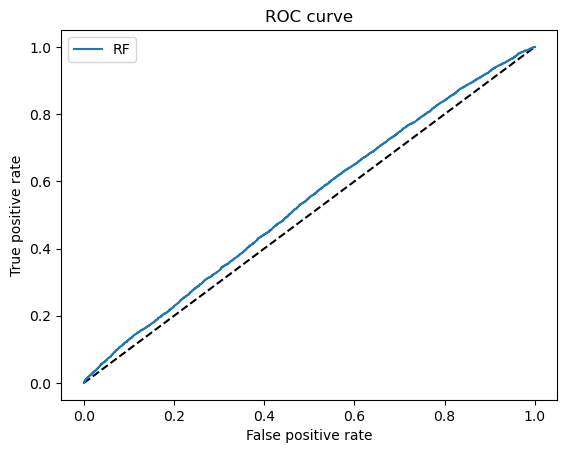

In [8]:
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt

# Performance Metrics
y_pred_rf = RF_fit.predict_proba(train_X)[:, 1]
y_pred = RF_fit.predict(train_X)
fpr_rf, tpr_rf, _ = roc_curve(train_y, y_pred_rf)
report = classification_report(train_y, y_pred, digits=4)
print(report)

print("Confusion Matrix")
print(confusion_matrix(train_y, y_pred))


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

report_dict = classification_report(train_y, y_pred, output_dict=True, digits=4)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv('results/classification_report(Train).csv', index=True, encoding='utf-8-sig')

### **Results(Test_dataset)**

              precision    recall  f1-score   support

        -1.0     0.5155    0.5395    0.5273      4526
         1.0     0.4964    0.4723    0.4840      4349

    accuracy                         0.5066      8875
   macro avg     0.5059    0.5059    0.5056      8875
weighted avg     0.5061    0.5066    0.5061      8875

Confusion Matrix
[[2442 2084]
 [2295 2054]]


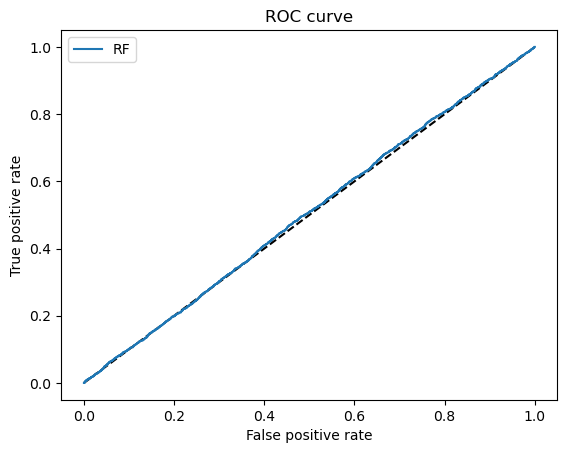

In [9]:
test_X = test_dataset.drop(columns=["label"])
test_y = test_dataset["label"]
# Performance Metrics
y_pred_rf = RF_fit.predict_proba(test_X)[:, 1]
y_pred = RF_fit.predict(test_X)
fpr_rf, tpr_rf, _ = roc_curve(test_y, y_pred_rf)
report = classification_report(test_y, y_pred, digits=4)
print(report)

print("Confusion Matrix")
print(confusion_matrix(test_y, y_pred))


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

report_dict = classification_report(test_y, y_pred, output_dict=True, digits=4)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv('results/classification_report(Test).csv', index=True, encoding='utf-8-sig')